### Import Dependencies

In [1]:
import random
random.seed(0)

In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

### Constant Variables

In [3]:
DATASET_PATH = './knee-osteoarthritis_2'

In [4]:
TRAIN_PATH = f'{DATASET_PATH}/train'
VAL_PATH = f'{DATASET_PATH}/val'
TEST_PATH = f'{DATASET_PATH}/test'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [6]:
classes = range(4)

### Dataset 

In [7]:
from src.dataset.augmented_dataset import get_KneeOsteoarthritis_Edges, KneeOsteoarthritis_Edges

transform_toTensor = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.ImageFolder(TRAIN_PATH, transform_toTensor)
val_dataset = torchvision.datasets.ImageFolder(VAL_PATH, transform_toTensor)
test_dataset = torchvision.datasets.ImageFolder(TEST_PATH, transform_toTensor)

dataset_all = torch.utils.data.ConcatDataset([train_dataset, val_dataset, test_dataset])

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset_all, [0.7, 0.1, 0.2])

train_dataset = KneeOsteoarthritis_Edges(train_dataset)
val_dataset = KneeOsteoarthritis_Edges(val_dataset)
test_dataset = KneeOsteoarthritis_Edges(test_dataset)

In [8]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

4736 676 1353


### Dataset Visualization

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def unnorm_img(x):
  return (x-np.min(x))/(np.max(x)-np.min(x))

# function to show some images from dataset
def plot_dataset(dataset, input_idx=0):
    rows, cols = 4, 4
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    
    if input_idx == 0:
      fig.suptitle('Original images', fontsize=16)
    elif input_idx == 1:
      fig.suptitle('Augmented images - focussed on vertical edge detection', fontsize=16)
      
    for idx, ax in enumerate(axes.ravel()):
      class_id = dataset[idx][1]
      img_clear = dataset[idx][0][input_idx]
      
      np_img_clear = img_clear.numpy()
      np_img_clear = unnorm_img(np_img_clear)
      
      ax.imshow(np.transpose(np_img_clear, (1, 2, 0)), cmap='gray')
      ax.set_title(f"{class_id}", fontsize=12)
      ax.axis('off')


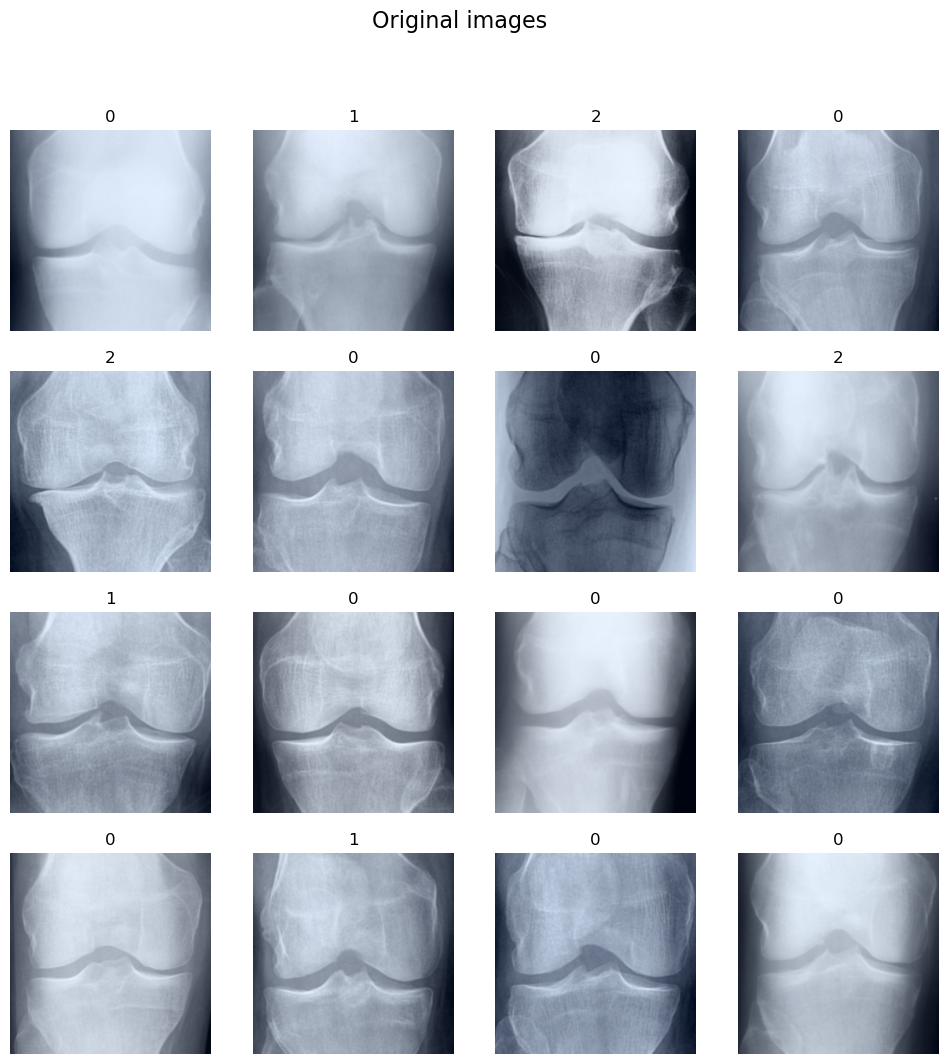

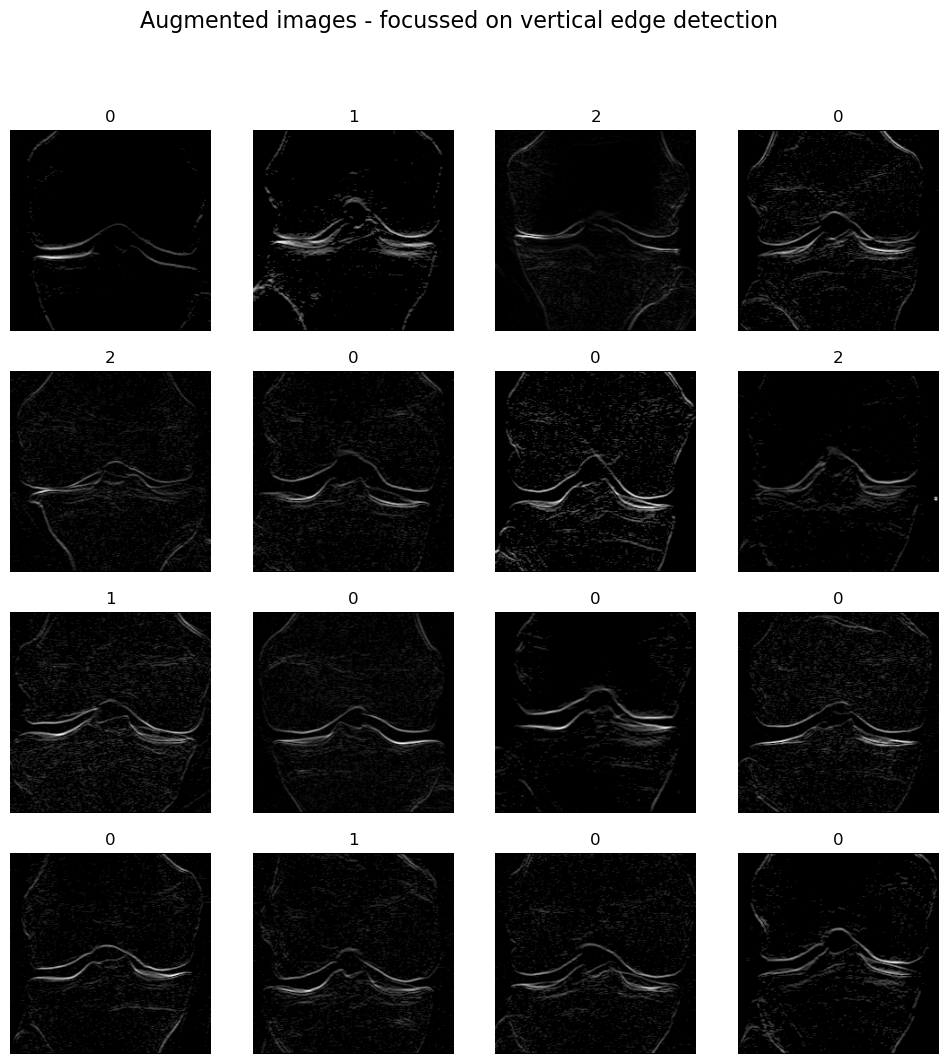

In [109]:
plot_dataset(train_dataset, 0)
plot_dataset(train_dataset, 1)

### Data Loader

In [10]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

### Model

In [11]:
class IntermediarySpaceModel(nn.Module):
    def __init__(self, train_device, num_classes: int = 5, dropout: float = 0.5) -> None:
        super().__init__()
        
        # Size of layer block
        S = 24
        self.train_device = train_device
        
        # Images
        self.imagesClassifier = nn.Sequential(
            nn.Conv2d(3, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.2),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 7 * 7, S*2),
        )

        self.edgesClassifier = nn.Sequential(
            nn.Conv2d(1, S*2, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.4),
            nn.Conv2d(S*2, S*2, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=dropout*0.6),
            nn.Conv2d(S*2, S, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Flatten(),
            nn.Dropout(p=dropout*0.8),
            nn.Linear(S * 6 * 6, S*2),
        )
        
        self.outputCombiner = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*4, S*3),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S*3, S),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Linear(S, num_classes),
        )
        
    def forward(self, data: tuple) -> torch.Tensor:
        
        images, edges = data
        
        images = images.to(self.train_device)
        edges = edges.to(self.train_device)
        
        # Images
        images = self.imagesClassifier(images)
        
        # Edges
        edges = self.edgesClassifier(edges)
        
        # Combining outputs
        concated = torch.cat((images, edges), 1)
        res = self.outputCombiner(concated)
        
        return res

In [12]:
model = IntermediarySpaceModel(device, 4, 0.5)
model = model.to(device)

In [13]:
# print(sum(p.numel() for p in net.classifier.parameters()) ,sum(p.numel() for p in net.edgesClassifier.parameters()) )
print(sum(p.numel() for p in model.parameters()))

trainable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print(sum(p.numel() for p in trainable_parameters))

287044
287044


### Configuring Trainer

#### Criterion & Optimizer

In [14]:
import torch.optim as optim
from src.other import get_classes_frequencies

class_weights = get_classes_frequencies(train_dataset)
weights_tensor = torch.Tensor(list(class_weights.values())).to(device)
print(class_weights, weights_tensor)

criterion = nn.CrossEntropyLoss(weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

{0: 2280, 1: 1516, 2: 761, 3: 179} tensor([2280., 1516.,  761.,  179.], device='cuda:0')


#### Decaying Learning Rate Scheduler

In [15]:
# decayRate100 = 0.8
decayRate100 = 0.4
decayRate1 = decayRate100**(1/100)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate1)

print(decayRate1)

0.9908789441918076


#### Tensorboard Logger

In [16]:
EXP_NAME = "confusion_matrix_test"

from torch.utils.tensorboard import SummaryWriter

# logger = SummaryWriter(log_dir=f"logs/test/{EXP_NAME}")
logger = SummaryWriter(log_dir=f"logs/test")

### Trainer

In [17]:
from src.training import Trainer

trainer = Trainer(
  model=model,
  classes=classes,
  train_loader=train_loader,
  val_loader=val_loader,
  criterion=criterion,
  optimizer=optimizer,
  device=device,
  lr_scheduler=lr_scheduler,
  reg_type="L2",
  reg_lambda=0.01,
  tensorboard_logger=logger
)

#### Model Results Visualization

In [18]:
from src.other import get_confusion_matrix_display

def visualize_all(model, epoch):
    tAccuracy, tLoss, tReport, tCm = trainer.evaluate(trainer.train_loader)
    vAccuracy, vLoss, vReport, vCm = trainer.evaluate(trainer.val_loader)
    print(f"training accuracy: {tAccuracy}, training loss: {tLoss}, validation accuracy: {vAccuracy}, validation loss: {vLoss}")
    print(f"Training report: {tReport}")
    print(f"Validation report: {vReport}")
    
    get_confusion_matrix_display(tCm, classes, "Training", epoch)
    get_confusion_matrix_display(vCm, classes, "Validation", epoch)

### Training Model

In [19]:
trainer.train_many(100)

Epoch 0: Training: accuracy: 42.568%, loss: 1.977; Validation: accuracy: 46.746%, loss: 1.115, lr: 0.00100
Epoch 1: Training: accuracy: 48.079%, loss: 1.629; Validation: accuracy: 48.373%, loss: 0.690, lr: 0.00099
Epoch 2: Training: accuracy: 48.142%, loss: 1.490; Validation: accuracy: 48.373%, loss: 0.797, lr: 0.00098
Epoch 3: Training: accuracy: 48.142%, loss: 1.491; Validation: accuracy: 48.373%, loss: 0.908, lr: 0.00097
Epoch 4: Training: accuracy: 48.184%, loss: 1.350; Validation: accuracy: 48.521%, loss: 0.850, lr: 0.00096
Epoch 5: Training: accuracy: 49.388%, loss: 1.165; Validation: accuracy: 51.479%, loss: 0.741, lr: 0.00096
Epoch 6: Training: accuracy: 53.970%, loss: 1.087; Validation: accuracy: 58.136%, loss: 0.751, lr: 0.00095
Epoch 7: Training: accuracy: 57.285%, loss: 1.061; Validation: accuracy: 56.509%, loss: 0.785, lr: 0.00094
Epoch 8: Training: accuracy: 61.655%, loss: 0.906; Validation: accuracy: 60.207%, loss: 0.709, lr: 0.00093
Epoch 9: Training: accuracy: 62.627%,

training accuracy: 96.2204391891892, training loss: 0.018496811389923096, validation accuracy: 68.19526627218934, validation loss: 0.8580447435379028
Training report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2280
           1       0.98      1.00      0.99      1516
           2       0.83      1.00      0.91       761
           3        nan      0.00      0.00       179

    accuracy                           0.96      4736
   macro avg       0.94      0.75      0.72      4736
weighted avg       0.97      0.96      0.94      4736

Validation report:               precision    recall  f1-score   support

           0       0.78      0.82      0.80       327
           1       0.57      0.58      0.57       224
           2       0.60      0.62      0.61       101
           3        nan      0.00      0.00        24

    accuracy                           0.68       676
   macro avg       0.65      0.51      0.50       676

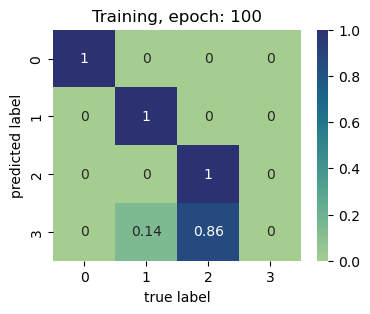

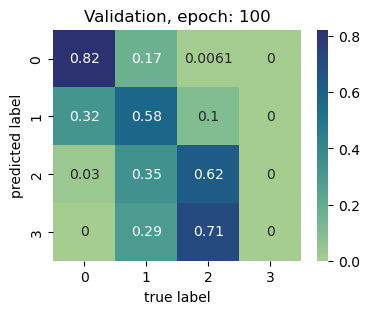

In [20]:
# test
visualize_all(model, trainer.epochCounter)